In [1]:
from setup_env import setup_environment

setup_environment()

In [2]:
from dataclasses import dataclass
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from project.machine_learning.classifier import SklearnAdvisor
from project.machine_learning.judge import CatboostJudge
from project.machine_learning.model_mc import ModelMC

from project.wfc.factory import Factory
from project.wfc.grid import Grid, Rect
from project.wfc.advisor import Advisor, RandomAdvisor
from project.wfc.judge import Judge, AlwaysContinueJudge, RandomJudge
from project.config import DATA_SOURCE
from project.wfc.wfc import WFC

In [12]:
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.set_context("talk")

In [4]:
factory = Factory(DATA_SOURCE)
patterns = factory.create_patterns()

INFO - Validation Result: success



In [5]:
@dataclass
class Benchmark:
    size: int
    target: int


benchmarks = [
    Benchmark(size=5, target=1_000),  # 25 cells
    Benchmark(size=7, target=1_000),  # 49 cells
    Benchmark(size=10, target=1_000),  # 100 cells
    Benchmark(size=14, target=100),  # 196 cells
    Benchmark(size=20, target=100),  # 400 cells
]

In [6]:
def evaluate_wfc(
    benchmarks: list[Benchmark], advisor: Advisor, judge: Judge, name: str
) -> pd.DataFrame:
    results = []
    for benchmark in tqdm(benchmarks):
        rect = Rect(width=benchmark.size, height=benchmark.size)
        grid = Grid(rect=rect, patterns=patterns)
        wfc = WFC(grid=grid, judge=judge, advisor=advisor)

        successful_generations, tries, steps = 0, 0, 0
        while successful_generations < benchmark.target:
            is_succeeded = wfc.generate()

            tries += 1
            steps += wfc.history.steps

            if is_succeeded:
                successful_generations += 1

        mean_steps = steps / benchmark.target
        mean_tries = tries / benchmark.target

        results.append(
            {
                "model": name,
                "size": benchmark.size**2,
                "mean_steps": mean_steps,
                "mean_tries": mean_tries,
            }
        )

    return pd.DataFrame(results)

In [7]:
random_advisor = RandomAdvisor()
continue_judge = AlwaysContinueJudge()

wfc_df = evaluate_wfc(benchmarks, random_advisor, continue_judge, "Classic")

wfc_df.head(5)

100%|██████████| 5/5 [15:04<00:00, 180.94s/it]


,model,size,mean_steps,mean_tries
0,Classic,25,25.868,1.071
1,Classic,49,53.487,1.201
2,Classic,100,131.876,1.780
3,Classic,196,399.270,3.880
4,Classic,400,3603.290,32.260


In [8]:
random_advisor = RandomAdvisor()
random_judge = RandomJudge(rollback_chance=0.1)

wfc_random_judge_df = evaluate_wfc(
    benchmarks, random_advisor, continue_judge, "Random Judge (0.1)"
)

wfc_random_judge_df.head(5)

100%|██████████| 5/5 [13:09<00:00, 157.87s/it]


,model,size,mean_steps,mean_tries
0,Random Judge (0.1),25,26.075,1.087
1,Random Judge (0.1),49,54.570,1.252
2,Random Judge (0.1),100,135.501,1.809
3,Random Judge (0.1),196,431.920,4.190
4,Random Judge (0.1),400,2899.270,25.450


In [9]:
random_advisor = RandomAdvisor()
threshold = 0.2
catboost_judge = CatboostJudge(
    weights="weights/judge/catboost.cbm", rollback_threshold=threshold
)

wfc_cb_2_judge_df = evaluate_wfc(
    benchmarks, random_advisor, catboost_judge, f"CatBoost Judge"
)
wfc_cb_2_judge_df.head(5)

100%|██████████| 5/5 [17:25<00:00, 209.01s/it]


,model,size,mean_steps,mean_tries
0,CatBoost Judge,25,25.894,1.075
1,CatBoost Judge,49,54.021,1.231
2,CatBoost Judge,100,131.846,1.784
3,CatBoost Judge,196,395.250,3.810
4,CatBoost Judge,400,3037.140,26.830


In [ ]:
dt_judge = SklearnAdvisor(view=Rect(width=5, height=5), threshold=0.8, rebalance=True)
dt_judge.load_weights("weights/decision_tree.pkl")

wfcwdt_df = evaluate_wfc(benchmarks, dt_judge, "Decision Tree")

wfcwdt_df.head(5)

100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


,model,size,mean_tries
0,WFC with Decision Tree,4,1.00
1,WFC with Decision Tree,9,1.02
2,WFC with Decision Tree,16,1.29
3,WFC with Decision Tree,25,1.26
4,WFC with Decision Tree,36,2.17


In [ ]:
knn_judge = SklearnAdvisor(view=Rect(width=5, height=5), threshold=0.5, rebalance=True)
knn_judge.load_weights("weights/k-nearest_neighbors.pkl")

wfcknn_df = evaluate_wfc(benchmarks, knn_judge, "kNN")

wfcknn_df.head(5)

100%|██████████| 10/10 [08:00<00:00, 48.07s/it] 


,model,size,mean_tries
0,WFC with kNN,4,1.01
1,WFC with kNN,9,1.07
2,WFC with kNN,16,1.24
3,WFC with kNN,25,1.36
4,WFC with kNN,36,1.87


In [ ]:
logreg_judge = SklearnAdvisor(
    view=Rect(width=5, height=5), threshold=0.8, rebalance=True
)
logreg_judge.load_weights("weights/logistic_regression.pkl")

wfclog_df = evaluate_wfc(benchmarks, logreg_judge, "LogReg")

wfclog_df.head(5)

100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


,model,size,mean_tries
0,WFC with LogReg,4,1.01
1,WFC with LogReg,9,1.03
2,WFC with LogReg,16,1.13
3,WFC with LogReg,25,1.38
4,WFC with LogReg,36,1.85


In [8]:
continue_judge = AlwaysContinueJudge()
forest_advisor = SklearnAdvisor(
    view=Rect(width=5, height=5), threshold=0.5, rebalance=True
)
forest_advisor.load_weights("weights/advisor/random_forest.pkl")

wfc_rf_advisor_df = evaluate_wfc(
    benchmarks, forest_advisor, continue_judge, "Random Forest Advisor"
)

wfc_rf_advisor_df.head(5)

100%|██████████| 5/5 [19:14<00:00, 230.81s/it]


,model,size,mean_steps,mean_tries
0,WFC with Random Forest Advisor,25,25.00,1.00
1,WFC with Random Forest Advisor,49,49.00,1.00
2,WFC with Random Forest Advisor,100,185.00,3.00
3,WFC with Random Forest Advisor,196,243.00,2.00
4,WFC with Random Forest Advisor,400,2437.87,20.73


In [ ]:
svm_judge = SklearnAdvisor(view=Rect(width=5, height=5), threshold=0.5, rebalance=True)
svm_judge.load_weights("weights/svm_(linear).pkl")

wfcsvm_df = evaluate_wfc(benchmarks, svm_judge, "SVM")

wfcsvm_df.head(5)

100%|██████████| 10/10 [02:34<00:00, 15.47s/it]


,model,size,mean_tries
0,WFC with SVM,4,1.01
1,WFC with SVM,9,1.03
2,WFC with SVM,16,1.13
3,WFC with SVM,25,1.37
4,WFC with SVM,36,2.10


In [ ]:
mc_judge = ModelMC(view=Rect(3, 3))
mc_judge.load_weights("data/weights/wfcwmc/mmc_1000")

wfcwmc_df = evaluate_wfc(benchmarks, mc_judge, "WFCWMC")

wfcwmc_df.head(5)

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


,model,size,mean_tries
0,WFCWMC,4,1.00
1,WFCWMC,9,1.02
2,WFCWMC,16,1.06
3,WFCWMC,25,1.08
4,WFCWMC,36,1.16


In [10]:
evaluation_df = pd.concat([wfc_df, wfc_random_judge_df, wfc_cb_2_judge_df]).reset_index(drop=True)

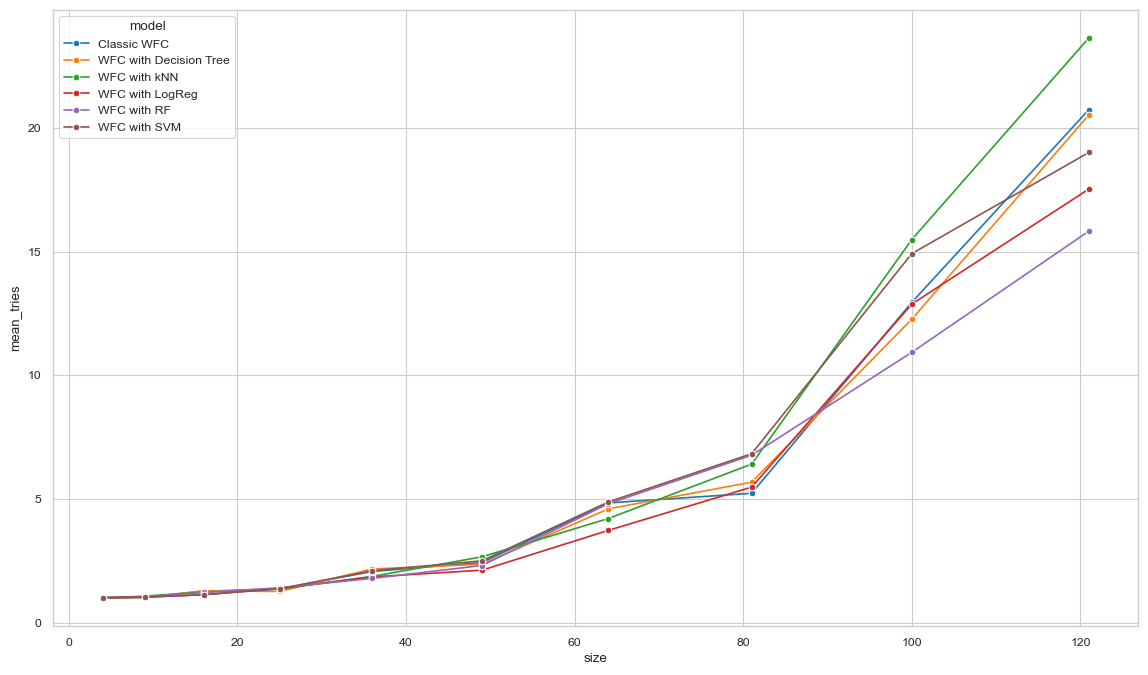

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=evaluation_df, x="size", y="mean_steps", hue="model", marker="o")
plt.savefig("content/performance.png", bbox_inches="tight")

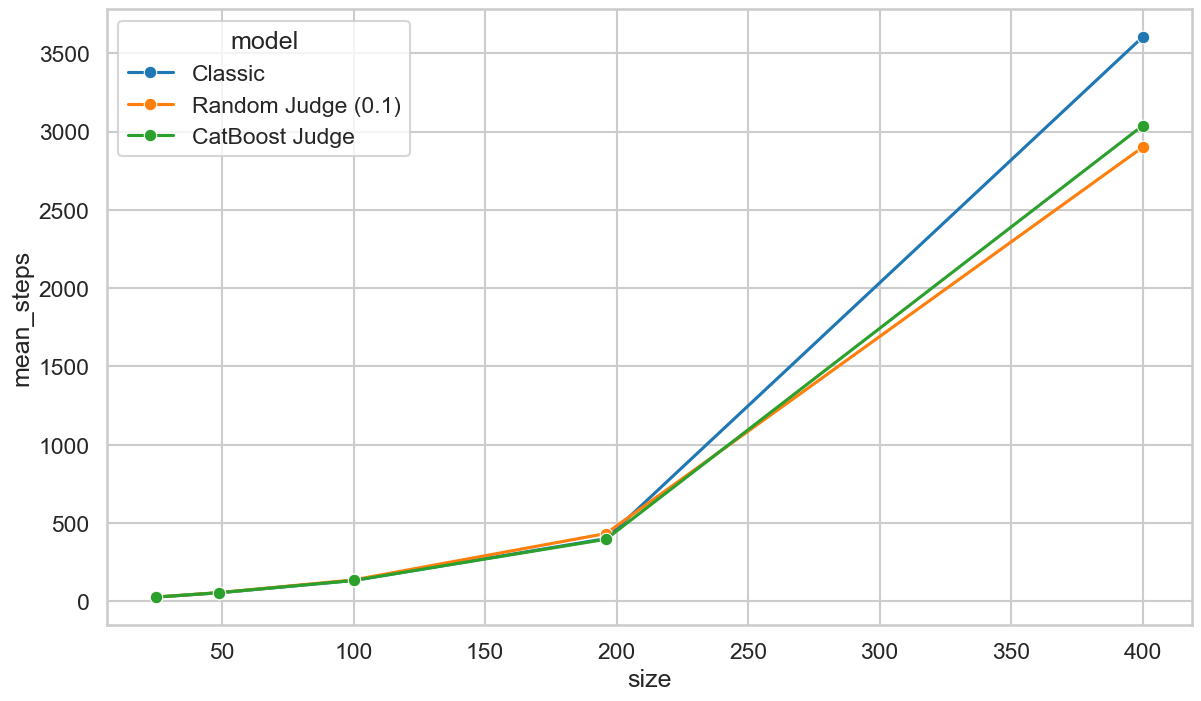

In [13]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=evaluation_df, x="size", y="mean_steps", hue="model", marker="o")
plt.savefig("content/performance.png", bbox_inches="tight")